In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from LughaatNLP import LughaatNLP
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns


# -----------------------------
# Load dataset
# -----------------------------
dataset = pd.read_csv(r'D:\Umer Notes\7th SEM\ML\PROJECT\combined_articles.csv')
dataset = dataset[['content', 'gold_label']].dropna()

print(dataset.head())
print(dataset['gold_label'].value_counts())


# -----------------------------
# Preprocessing Functions
# -----------------------------
preprocessor = LughaatNLP()

def preprocess(text):
    text = preprocessor.normalize(text)
    text = preprocessor.remove_stopwords(text)
    text = preprocessor.lemmatize_sentence(text)
    tokens = preprocessor.urdu_tokenize(text)
    return tokens

def add_bigrams(tokens):
    bigrams = [tokens[i] + "_" + tokens[i+1] for i in range(len(tokens)-1)]
    return tokens + bigrams


# Apply preprocessing and bigrams
dataset['content'] = dataset['content'].astype(str).apply(preprocess)
dataset['content'] = dataset['content'].apply(add_bigrams)

# -----------------------------
# Train / Test Split
# -----------------------------
documents = dataset['content']
labels = dataset['gold_label']

X_train, X_test, y_train, y_test = train_test_split(
    documents,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# Consistent class ordering
LABELS = sorted(dataset['gold_label'].unique())
print("LABELS:", LABELS)


W1209 20:34:44.139000 21908 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


                                             content     gold_label
0  بیجنگ : چینی ائیر شو میں سیکستھ جنیریش جدید طی...  entertainment
1  کراچی : وزیر اطلاعات سندھ شرجیل میمن کا کہنا ہ...  entertainment
2  سڈنی: تین ٹی ٹوئنٹی میچوں کی سیریز کے دوسرے می...  entertainment
3  اسلامی نظریاتی کونسل کی جانب سے دیئےگئے فتوے ک...  entertainment
4  یہ اشتہار میں اپنے گم شدہ بھائی چنتا منی کے مت...  entertainment
gold_label
sports                220
entertainment         219
world                 218
business              212
science-technology    205
Name: count, dtype: int64
Train size: 859
Test size: 215
LABELS: ['business', 'entertainment', 'science-technology', 'sports', 'world']


Alpha tuning:
alpha=0.1: train_acc=0.901, val_acc=0.833, train_loss=2220.622, val_loss=1943.619
alpha=0.3: train_acc=0.898, val_acc=0.833, train_loss=2230.315, val_loss=1940.781
alpha=0.5: train_acc=0.898, val_acc=0.833, train_loss=2239.436, val_loss=1943.712
alpha=0.7: train_acc=0.898, val_acc=0.837, train_loss=2248.032, val_loss=1948.028
alpha=1.0: train_acc=0.896, val_acc=0.837, train_loss=2260.037, val_loss=1955.275
alpha=1.5: train_acc=0.894, val_acc=0.837, train_loss=2278.004, val_loss=1967.514
alpha=2.0: train_acc=0.894, val_acc=0.837, train_loss=2293.862, val_loss=1979.088

Best alpha = 0.7 | Validation Accuracy = 0.837


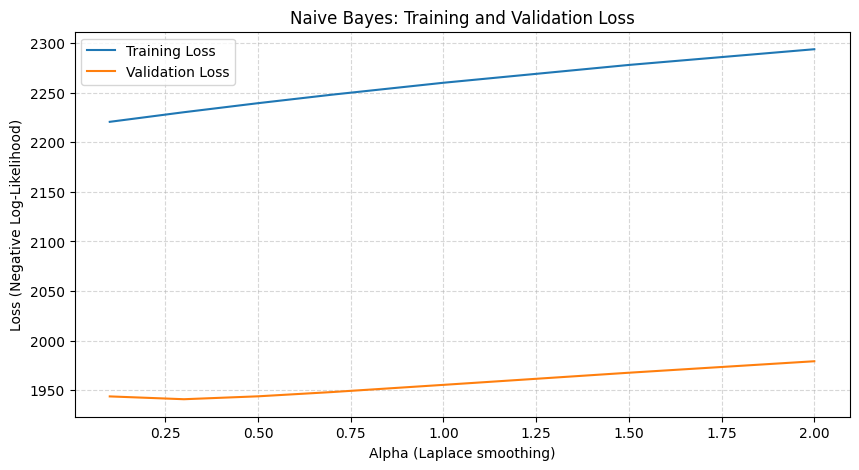

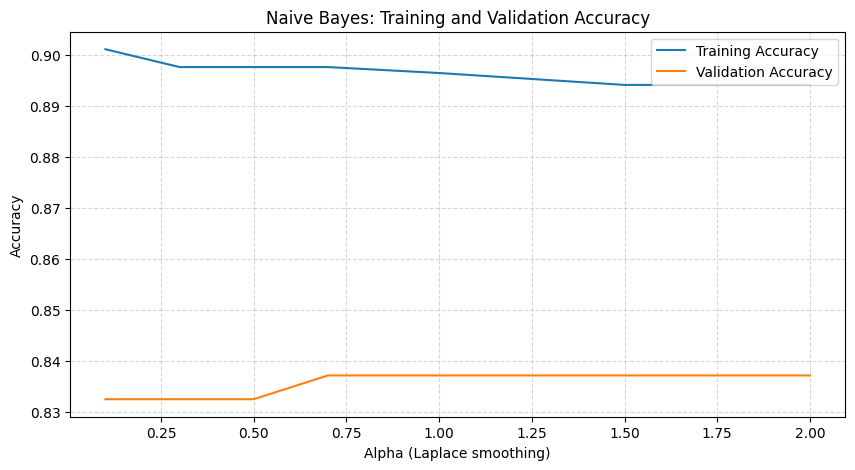


Final Test Accuracy (alpha=0.7): 0.837
Final Test Loss (NLL): 1948.028

Classification Report:
                    precision    recall  f1-score   support

          business       0.95      0.88      0.91        42
     entertainment       0.97      0.82      0.89        44
science-technology       0.76      0.76      0.76        41
            sports       0.80      0.84      0.82        44
             world       0.75      0.89      0.81        44

          accuracy                           0.84       215
         macro avg       0.85      0.84      0.84       215
      weighted avg       0.85      0.84      0.84       215



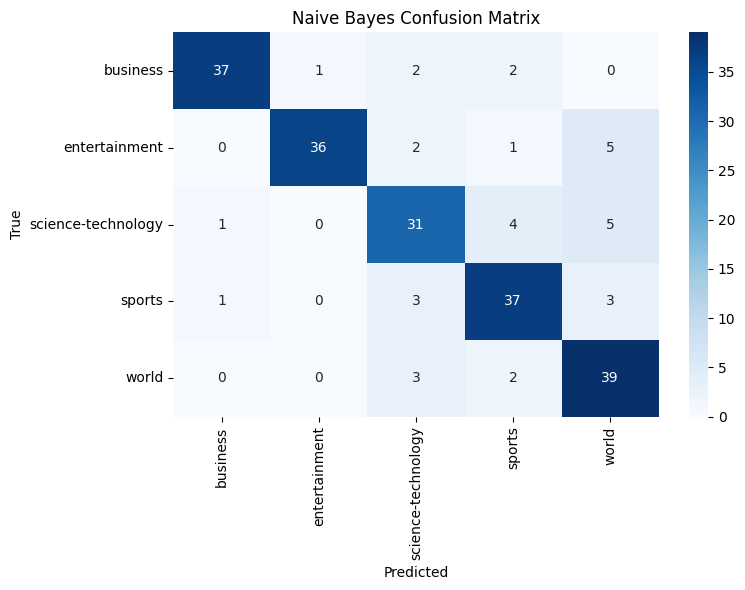


Accuracy per class:
business: 88.10%
entertainment: 81.82%
science-technology: 75.61%
sports: 84.09%
world: 88.64%


In [2]:
def calculate_class_probabilities(y_train):
    class_probabilities = defaultdict(int)
    total = len(y_train)
    for label in y_train:
        class_probabilities[label] += 1
    for label in class_probabilities:
        class_probabilities[label] /= total
    return class_probabilities


# -----------------------------
# Train Naive Bayes
# -----------------------------
def train_naive_bayes(X_train, y_train, min_freq=3, max_doc_ratio=0.8, bernoulli=False):
    global_counts = Counter()
    doc_counts = Counter()
    num_docs = len(X_train)

    # Global term stats
    for doc in X_train:
        tokens = list(doc)
        global_counts.update(tokens)
        doc_counts.update(set(tokens))

    # Build vocabulary
    vocab = set()
    for word, count in global_counts.items():
        if count < min_freq:
            continue
        if (doc_counts[word] / num_docs) > max_doc_ratio:
            continue
        vocab.add(word)

    # Class word frequencies
    class_word_freq = defaultdict(lambda: defaultdict(int))
    class_doc_count = defaultdict(int)

    for doc, label in zip(X_train, y_train):
        class_doc_count[label] += 1
        tokens = set(doc) if bernoulli else doc
        for word in tokens:
            if word in vocab:
                class_word_freq[label][word] += 1

    return vocab, class_word_freq, class_doc_count


# Train NB model once
vocab, class_word_freq, class_doc_count = train_naive_bayes(
    X_train,
    y_train,
    min_freq=3,
    max_doc_ratio=0.8,
    bernoulli=False
)

class_probabilities = calculate_class_probabilities(y_train)


# -----------------------------
# SINGLE-DOC PREDICTION (used by OCR)
# -----------------------------
def predict_naive_bayes(doc, vocab, class_word_freq, class_doc_count,
                        class_probabilities, alpha=0.5):
    """
    Predicts the most likely class for ONE document.
    This is what classify_image_cloud() uses.
    """
    vocab_size = len(vocab)
    scores = {}

    for label in class_probabilities:
        log_prob = np.log(class_probabilities[label])
        total_words = sum(class_word_freq[label].values())

        for word in doc:
            if word not in vocab:
                continue
            freq = class_word_freq[label].get(word, 0)
            log_prob += np.log((freq + alpha) / (total_words + alpha * vocab_size))

        scores[label] = log_prob

    return max(scores, key=scores.get)


# -----------------------------
# Evaluate NB: accuracy + loss (for curves)
# -----------------------------
def evaluate_nb(X, y, alpha):
    """
    Returns (accuracy, average NLL loss, predictions)
    Loss = negative log-likelihood of true class
    """
    preds = []
    losses = []

    vocab_size = len(vocab)

    for doc, true_label in zip(X, y):
        log_scores = {}

        for label in class_probabilities:
            log_prob = np.log(class_probabilities[label])
            total_words = sum(class_word_freq[label].values())

            for word in doc:
                if word not in vocab:
                    continue
                freq = class_word_freq[label].get(word, 0)
                log_prob += np.log((freq + alpha) / (total_words + alpha * vocab_size))

            log_scores[label] = log_prob

        # prediction
        pred_label = max(log_scores, key=log_scores.get)
        preds.append(pred_label)

        # loss for this sample = - log P(true_label | doc)
        true_log_prob = log_scores[true_label]
        losses.append(-true_log_prob)

    acc = accuracy_score(y, preds)
    avg_loss = float(np.mean(losses))
    return acc, avg_loss, preds


# -----------------------------
# Tune Alpha + collect curves
# -----------------------------
alphas = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
best_alpha = None
best_val_acc = 0.0

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

print("Alpha tuning:")
for a in alphas:
    train_acc, train_loss, _ = evaluate_nb(X_train, y_train, alpha=a)
    val_acc, val_loss, _ = evaluate_nb(X_test, y_test, alpha=a)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"alpha={a}: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}, "
          f"train_loss={train_loss:.3f}, val_loss={val_loss:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_alpha = a

print(f"\nBest alpha = {best_alpha} | Validation Accuracy = {best_val_acc:.3f}")

# -----------------------------
# Plot LOSS curves (like LSTM)
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(alphas, train_losses, label='Training Loss')
plt.plot(alphas, val_losses, label='Validation Loss')
plt.title('Naive Bayes: Training and Validation Loss')
plt.xlabel('Alpha (Laplace smoothing)')
plt.ylabel('Loss (Negative Log-Likelihood)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# -----------------------------
# Plot ACCURACY curves
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(alphas, train_accuracies, label='Training Accuracy')
plt.plot(alphas, val_accuracies, label='Validation Accuracy')
plt.title('Naive Bayes: Training and Validation Accuracy')
plt.xlabel('Alpha (Laplace smoothing)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# -----------------------------
# FINAL Predictions with best alpha
# -----------------------------
final_acc, final_loss, y_pred = evaluate_nb(X_test, y_test, alpha=best_alpha)

print(f"\nFinal Test Accuracy (alpha={best_alpha}): {final_acc:.3f}")
print(f"Final Test Loss (NLL): {final_loss:.3f}")

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    labels=LABELS,
    target_names=LABELS
))

# -----------------------------
# Confusion Matrix
# -----------------------------
conf_matrix = confusion_matrix(y_test, y_pred, labels=LABELS)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABELS, yticklabels=LABELS)
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# -----------------------------
# Per-class Accuracy (2 decimal places)
# -----------------------------
y_test_arr = np.array(y_test)
y_pred_arr = np.array(y_pred)

print("\nAccuracy per class:")
for label in LABELS:
    idx = np.where(y_test_arr == label)[0]
    if len(idx) == 0:
        print(f"{label}: no samples in test set")
        continue
    correct = np.sum(y_test_arr[idx] == y_pred_arr[idx])
    class_acc = correct / len(idx)
    print(f"{label}: {class_acc * 100:.2f}%")


## **OCR**

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"D:\Umer Notes\7th SEM\ML\PROJECT\KEYS\urdu-ocr-480714-fc60bb78cd98.json"
print("Credential path set!")

Credential path set!


In [4]:
from google.cloud import vision
import io
import matplotlib.image as mpimg

In [ ]:
def ocr_cloud_vision(image_path):
    """
    Uses Google Cloud Vision to extract text from an image.
    Works for Urdu and mixed-language headlines.
    """
    # Create Vision API client
    client = vision.ImageAnnotatorClient()

    # Read image bytes
    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # Perform text detection
    response = client.text_detection(image=image)

    # Handle API errors
    if response.error.message:
        raise Exception(f"Google Vision API Error: {response.error.message}")

    texts = response.text_annotations

    if not texts:
        return ""

    # First element contains the full detected text
    full_text = texts[0].description
    return full_text

In [ ]:
def classify_image_cloud(image_path):
    """
    1) Runs OCR on the image (Google Vision)
    2) Preprocesses the text (LughaatNLP + bigrams)
    3) Predicts label using your trained Naive Bayes model
    """
    # Step 1: OCR
    raw_text = ocr_cloud_vision(image_path)

    # Step 2: Preprocess using your existing pipeline
    tokens = preprocess(raw_text)
    tokens = add_bigrams(tokens)

    # Step 3: Predict using trained Naive Bayes
    predicted_label = predict_naive_bayes(
        tokens,
        vocab,
        class_word_freq,
        class_doc_count,
        class_probabilities,
        alpha=best_alpha
    )

    return raw_text, predicted_label

OCR TEXT
انتظار ختم ، اسلام آباد میں آج سے انٹر نیشنل ریسلنگ میلہ شروع

PREDICTED LABEL
science-technology


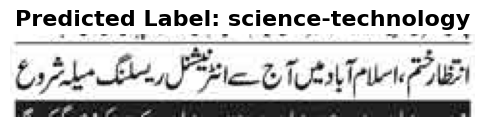

In [13]:
test_image_path = r"D:\Umer Notes\7th SEM\ML\PROJECT\OCR ACC\sports\258.png"

ocr_text, predicted = classify_image_cloud(test_image_path)

print("OCR TEXT")
print(ocr_text)
print("\nPREDICTED LABEL")
print(predicted)

# --------------------------
# DISPLAY IMAGE WITH LABEL
# --------------------------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(test_image_path)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Label: {predicted}", fontsize=16, fontweight='bold')
plt.show()